# Programming with RDDs

#### Links

* https://spark.apache.org/docs/1.6.0/programming-guide.html#resilient-distributed-datasets-rdds
* https://spark.apache.org/docs/1.1.1/api/python/pyspark.rdd.RDD-class.html

In [157]:
%matplotlib inline
%config InlineBackend.figure_format ='retina'

import os
import sys
import glob
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import sys
import json
sys.path.append('./')

from utils import *


os.environ["PYSPARK_PYTHON"] = "/usr/bin/python3.5"

In [2]:
!spark-submit --version

Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /___/ .__/\_,_/_/ /_/\_\   version 1.6.0
      /_/
                        
Type --help for more information.


## Запускаем Spark

In [3]:
import pyspark
from pyspark.conf import SparkConf
from pyspark.sql import SQLContext


conf = SparkConf()
conf.setMaster("yarn-client")
conf.set("spark.executor.memory", "4g")
conf.set("spark.core.connection.ack.wait.timeout", "1200")

# conf.set("spark.dynamicAllocation.enabled", "true")
# conf.set("spark.shuffle.service.enabled", "true")
# conf.set("spark.dynamicAllocation.initialExecutors", 2)
# conf.set("spark.dynamicAllocation.maxExecutors", 2)

sc = pyspark.SparkContext(conf = conf)
sc.addPyFile('./utils.py')
sqlContext = SQLContext(sc)

## Работа с hdfs

Утилитой командной строки -- `hdfs` (https://hadoop.apache.org/docs/current/hadoop-project-dist/hadoop-common/FileSystemShell.html)

Полезные команды:
* `hdfs dfs -ls [<path>]`
* `hdfs dfs -rm <path>`
* `hdfs dfs -mv <src> <dst>`
* `hdfs dfs -copyToLocal <src> <dst local>`
* `hdfs dfs -copyFromLocal <src local> <dst>`


### Копирование данных

Прежде чем начать работать с самим данными их нужно сохранить в hdfs.

1. Запустите terminal через Jupyter
2. `hdfs dfs -copyFromLocal data .`


Проверяем, что все данные на месте

In [13]:
!hdfs dfs -copyFromLocal data .

In [14]:
!hdfs dfs -ls data/ml-25m/

Found 9 items
-rw-r--r--   1 root supergroup      10460 2020-02-04 17:06 data/ml-25m/README.txt
-rw-r--r--   1 root supergroup  435164157 2020-02-04 17:06 data/ml-25m/genome-scores.csv
-rw-r--r--   1 root supergroup      18103 2020-02-04 17:06 data/ml-25m/genome-tags.csv
-rw-r--r--   1 root supergroup    1368578 2020-02-04 17:06 data/ml-25m/links.csv
-rw-r--r--   1 root supergroup      12022 2020-02-04 17:06 data/ml-25m/ml-25m-README.htm
-rw-r--r--   1 root supergroup    3038099 2020-02-04 17:06 data/ml-25m/movies.csv
-rw-r--r--   1 root supergroup  678260987 2020-02-04 17:07 data/ml-25m/ratings.csv
-rw-r--r--   1 root supergroup   38810332 2020-02-04 17:07 data/ml-25m/tags.csv
-rw-r--r--   1 root supergroup  404281742 2020-02-04 17:07 data/ml-25m/tmdb.json


### Чтение данных

*Замечание*: Файл `ml-25m-README.htm` содержит описание данных

In [15]:
DATA_PATH = 'data/ml-25m'

RATINGS_PATH = os.path.join(DATA_PATH, 'ratings.csv')
MOVIES_PATH = os.path.join(DATA_PATH, 'movies.csv')
TAGS_PATH = os.path.join(DATA_PATH, 'tags.csv')

In [16]:
ratings = sc.textFile(RATINGS_PATH)

In [17]:
ratings.take(5)

['userId,movieId,rating,timestamp',
 '1,296,5.0,1147880044',
 '1,306,3.5,1147868817',
 '1,307,5.0,1147868828',
 '1,665,5.0,1147878820']

In [18]:
ratings.getNumPartitions()

5

In [19]:
ratings = ratings \
    .map(lambda s: s.split(',')) \
    .filter(lambda arr: arr[0].isdigit()) \
    .map(lambda arr: Rating(user_id=int(arr[0]), 
                            movie_id=int(arr[1]), 
                            rating=float(arr[2]), 
                            timestamp=int(arr[3])))

In [20]:
ratings.count()

25000095

Количество пользователей

In [21]:
%%time

ratings \
    .map(lambda r: r.user_id)\
    .distinct()\
    .count()

CPU times: user 207 ms, sys: 56 ms, total: 263 ms
Wall time: 5min 56s


162541

Сохраним датасет в память

In [22]:
ratings = ratings.persist()

In [23]:
%%time

ratings \
    .map(lambda r: r.user_id)\
    .distinct()\
    .count()

CPU times: user 633 ms, sys: 233 ms, total: 866 ms
Wall time: 12min 7s


162541

Количество фильмов

In [24]:
ratings \
    .map(lambda r: r.movie_id)\
    .distinct()\
    .count()

59047

## Упражнения

### Фильмы с наибольшим средним рейтингом

Найти 10 фильмов с наибольшим средним рейтингом. Вывести их названия и средний рейтинг

In [25]:
movies = sc.textFile(MOVIES_PATH)
movies.take(5)

['movieId,title,genres',
 '1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy',
 '2,Jumanji (1995),Adventure|Children|Fantasy',
 '3,Grumpier Old Men (1995),Comedy|Romance',
 '4,Waiting to Exhale (1995),Comedy|Drama|Romance']

In [26]:
movies = movies \
    .map(lambda s: s.split(',')[:2]) \
    .filter(lambda arr: arr[0].isdigit()) \
    .keyBy(lambda arr: int(arr[0]))

movie_avg_rating = ratings \
    .map(lambda r: (r.movie_id, (r.rating, 1))) \
    .reduceByKey(lambda a, b: (a[0] + b[0], a[1] + b[1])) \
    .mapValues(lambda ratings: ratings[0] / ratings[1])

movie_avg_rating \
    .join(movies) \
    .sortBy(lambda key_value: key_value[1][0], ascending=False)\
    .take(10)

[(196959, (5.0, ['196959', 'I Am JFK Jr. (2016)'])),
 (180663, (5.0, ['180663', '"Goodbye'])),
 (147966, (5.0, ['147966', "Tarzan's Fight for Life (1958)"])),
 (131628, (5.0, ['131628', 'Loaded (2014)'])),
 (131922, (5.0, ['131922', 'Private Duty Nurses (1971)'])),
 (188573, (5.0, ['188573', 'Judy (2014)'])),
 (164787, (5.0, ['164787', 'You Cast A Spell On Me (2015)'])),
 (132321, (5.0, ['132321', 'Black Oak Conspiracy (1977)'])),
 (165221, (5.0, ['165221', 'Elf Bowling the Movie (2007)'])),
 (149268, (5.0, ['149268', 'The Pied Piper (1942)']))]

Сохраните `rdd`, состоящий из строк вида `<movie_id>,<average_rating>` на hdfs в виде текстового файла

In [27]:
movie_avg_rating\
    .repartition(10) \
    .saveAsTextFile(os.path.join(DATA_PATH, 'movie_avg_rating'))

In [28]:
! hdfs dfs -ls data/ml-25m/movie_avg_rating

Found 11 items
-rw-r--r--   1 root supergroup          0 2020-02-04 17:39 data/ml-25m/movie_avg_rating/_SUCCESS
-rw-r--r--   1 root supergroup      58903 2020-02-04 17:39 data/ml-25m/movie_avg_rating/part-00000
-rw-r--r--   1 root supergroup     112361 2020-02-04 17:39 data/ml-25m/movie_avg_rating/part-00001
-rw-r--r--   1 root supergroup     131524 2020-02-04 17:39 data/ml-25m/movie_avg_rating/part-00002
-rw-r--r--   1 root supergroup     114377 2020-02-04 17:39 data/ml-25m/movie_avg_rating/part-00003
-rw-r--r--   1 root supergroup     133576 2020-02-04 17:39 data/ml-25m/movie_avg_rating/part-00004
-rw-r--r--   1 root supergroup     117783 2020-02-04 17:39 data/ml-25m/movie_avg_rating/part-00005
-rw-r--r--   1 root supergroup     143242 2020-02-04 17:39 data/ml-25m/movie_avg_rating/part-00006
-rw-r--r--   1 root supergroup     131984 2020-02-04 17:39 data/ml-25m/movie_avg_rating/part-00007
-rw-r--r--   1 root supergroup     167729 2020-02-04 17:39 data/ml-25m/movie_avg_rating/part-000

### Популярность тэгов

Найти 20 наиболее популярных тэгов

In [29]:
tags = sc.textFile(TAGS_PATH)
tags.take(5)

['userId,movieId,tag,timestamp',
 '3,260,classic,1439472355',
 '3,260,sci-fi,1439472256',
 '4,1732,dark comedy,1573943598',
 '4,1732,great dialogue,1573943604']

In [30]:
tags_count = tags\
    .map(lambda s: (s.split(',')[2], 1))\
    .reduceByKey(lambda a, b: a + b)\
    .collect()

len(tags_count)

73016

In [31]:
tags_count = sorted(tags_count, key=lambda tag_count: tag_count[1], reverse=True)

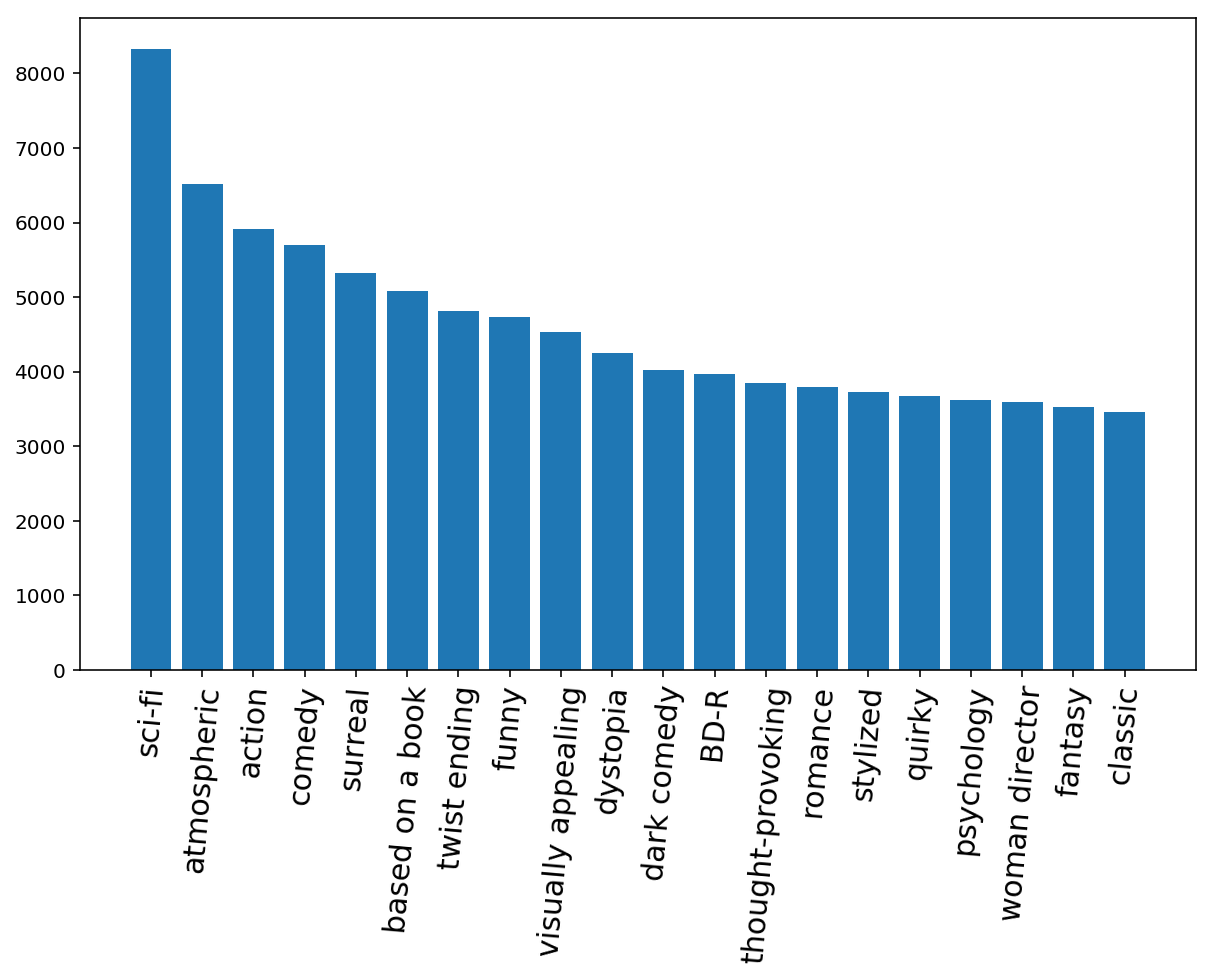

In [32]:
keys, values = zip(*tags_count[:20])

f, ax = plt.subplots(figsize=(10, 6))
plt.xticks(rotation=85, fontsize=15)
plt.bar(keys, values, align="center")
plt.show()

### Фильмы с наибольшим числом оценок

Найти 10 фильмов с наибольшим числом оценок. Вывести их названия и число оценок

In [37]:
######################################
######### YOUR CODE HERE #############
######################################

ratings \
    .map(lambda r: (r.movie_id, 1))\
    .reduceByKey(lambda a, b: a + b)\
    .join(movies) \
    .sortBy(lambda key_value: key_value[1], ascending=False)\
    .take(10)

[(356, (81491, ['356', 'Forrest Gump (1994)'])),
 (318, (81482, ['318', '"Shawshank Redemption'])),
 (296, (79672, ['296', 'Pulp Fiction (1994)'])),
 (593, (74127, ['593', '"Silence of the Lambs'])),
 (2571, (72674, ['2571', '"Matrix'])),
 (260, (68717, ['260', 'Star Wars: Episode IV - A New Hope (1977)'])),
 (480, (64144, ['480', 'Jurassic Park (1993)'])),
 (527, (60411, ['527', "Schindler's List (1993)"])),
 (110, (59184, ['110', 'Braveheart (1995)'])),
 (2959, (58773, ['2959', 'Fight Club (1999)']))]

### Фильмы с наибольшим числом 5

Найти 10 фильмов с наибольшим числом 5ок в качестве оценки. Вывести их названия и число 5ок

In [38]:
######################################
######### YOUR CODE HERE #############
######################################

ratings \
    .filter(lambda r: r.rating == 5.0) \
    .map(lambda r: (r.movie_id, 1))\
    .reduceByKey(lambda a, b: a + b)\
    .join(movies) \
    .sortBy(lambda key_value: key_value[1], ascending=False)\
    .take(10)

[(318, (39553, ['318', '"Shawshank Redemption'])),
 (296, (32169, ['296', 'Pulp Fiction (1994)'])),
 (356, (25918, ['356', 'Forrest Gump (1994)'])),
 (260, (25804, ['260', 'Star Wars: Episode IV - A New Hope (1977)'])),
 (2571, (25482, ['2571', '"Matrix'])),
 (527, (24853, ['527', "Schindler's List (1993)"])),
 (593, (24801, ['593', '"Silence of the Lambs'])),
 (858, (24418, ['858', '"Godfather'])),
 (50, (21585, ['50', '"Usual Suspects'])),
 (2959, (21486, ['2959', 'Fight Club (1999)']))]

### Распределение рейтингов фильмов

Построить распределение фильмов по ср. рейтингам  (гистограмму)

In [49]:
######################################
######### YOUR CODE HERE #############
######################################

rate_count = movie_avg_rating \
    .map(lambda arr: (round(arr[1], 2), 1))\
    .reduceByKey(lambda a, b: a + b)\
    .collect()

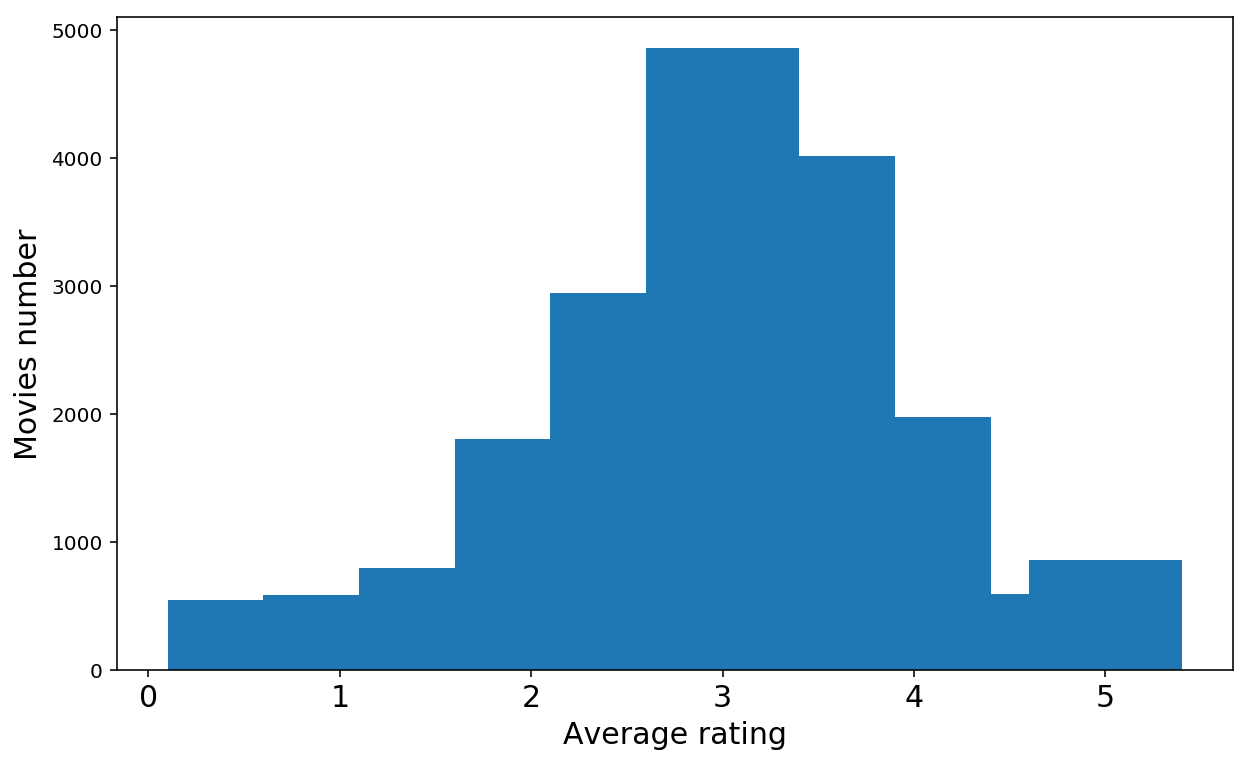

In [50]:
keys, values = zip(*rate_count)

f, ax = plt.subplots(figsize=(10, 6))
plt.xticks(rotation=0, fontsize=15)
plt.bar(keys, values, align="center")
plt.xlabel("Average rating", fontsize=15)
plt.ylabel("Movies number", fontsize=15)
plt.show()

### Распределение числа оценок для фильмов

Построить распределение фильмов по числу оценок

In [117]:
######################################
######### YOUR CODE HERE #############
######################################

categories = [10, 100, 500, 1000, 10000, 100000]

films_count = ratings \
    .map(lambda r: (r.movie_id, 1)) \
    .reduceByKey(lambda a, b: a + b) \
    .map(lambda arr: (next(cat for cat in categories if arr[1] < cat), 1)) \
    .reduceByKey(lambda a, b: a + b) \
    .collect()

In [118]:
films_count

[(100000, 588),
 (10000, 3206),
 (500, 4940),
 (1000, 1592),
 (100, 14004),
 (10, 34717)]

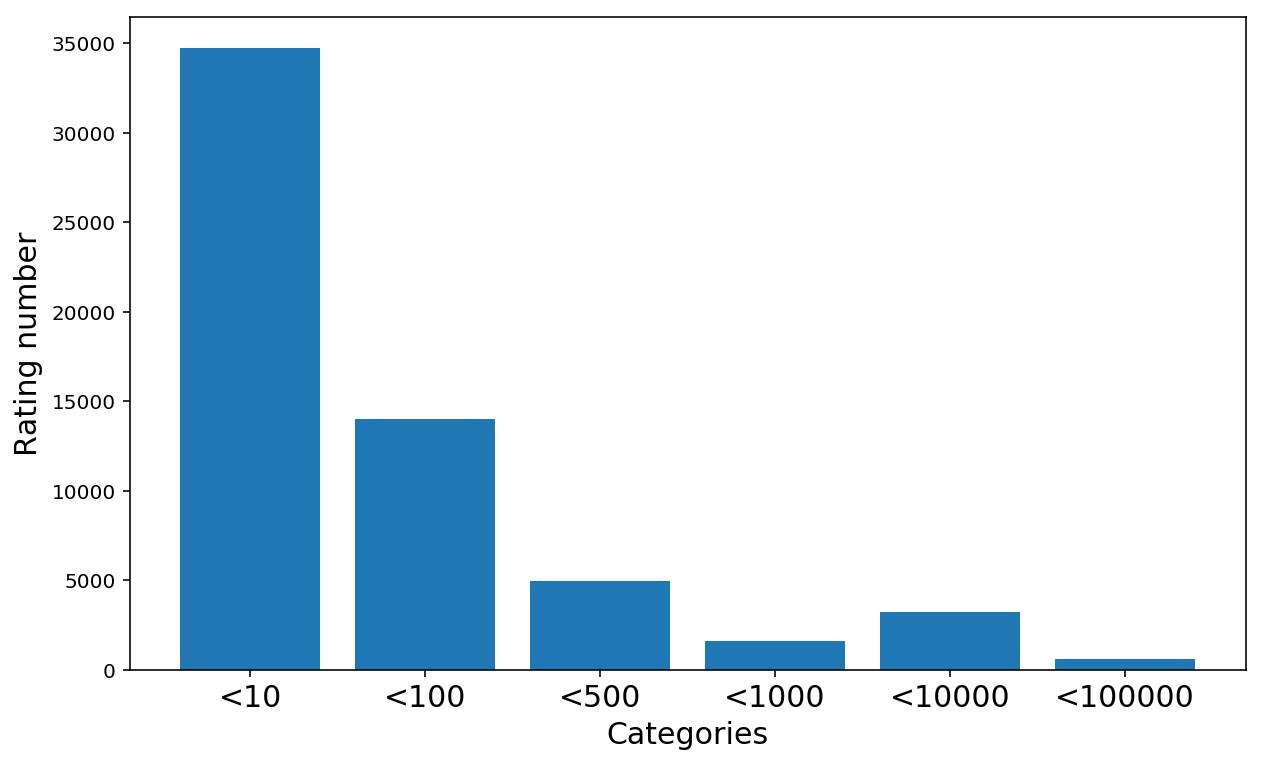

In [119]:
keys, values = zip(*sorted(films_count))

f, ax = plt.subplots(figsize=(10, 6))
plt.xticks(rotation=0, fontsize=15)
plt.bar(['<' + str(key) for key in keys], values, align="center")
# каждая категория -- верхняя граница количества оценок 
plt.xlabel("Categories", fontsize=15)
plt.ylabel("Rating number", fontsize=15)
plt.show()

### Распределение фильмов по жанрам

Построить гистограмму распределения фильмов по жанрам. Обратите внимание, что у фильма может быть указано больше одного жанра.

In [121]:
genres =  sc.textFile(MOVIES_PATH) \
    .map(lambda s: s.split(',')[::2]) \
    .filter(lambda arr: arr[0].isdigit()) \
    .filter(lambda arr: '(' not in arr[1] and ')' not in arr[1]) \
    .keyBy(lambda arr: int(arr[0]))

genres.take(3)

[(1, ['1', 'Adventure|Animation|Children|Comedy|Fantasy']),
 (2, ['2', 'Adventure|Children|Fantasy']),
 (3, ['3', 'Comedy|Romance'])]

In [131]:
######################################
######### YOUR CODE HERE #############
######################################

top_genres = genres \
    .flatMap(lambda arr: arr[1][1].split("|")) \
    .map(lambda genre: (genre.strip(), 1)) \
    .reduceByKey(lambda a, b: a + b) \
    .sortBy(lambda key_value: key_value[1], ascending=False)\
    .take(15)

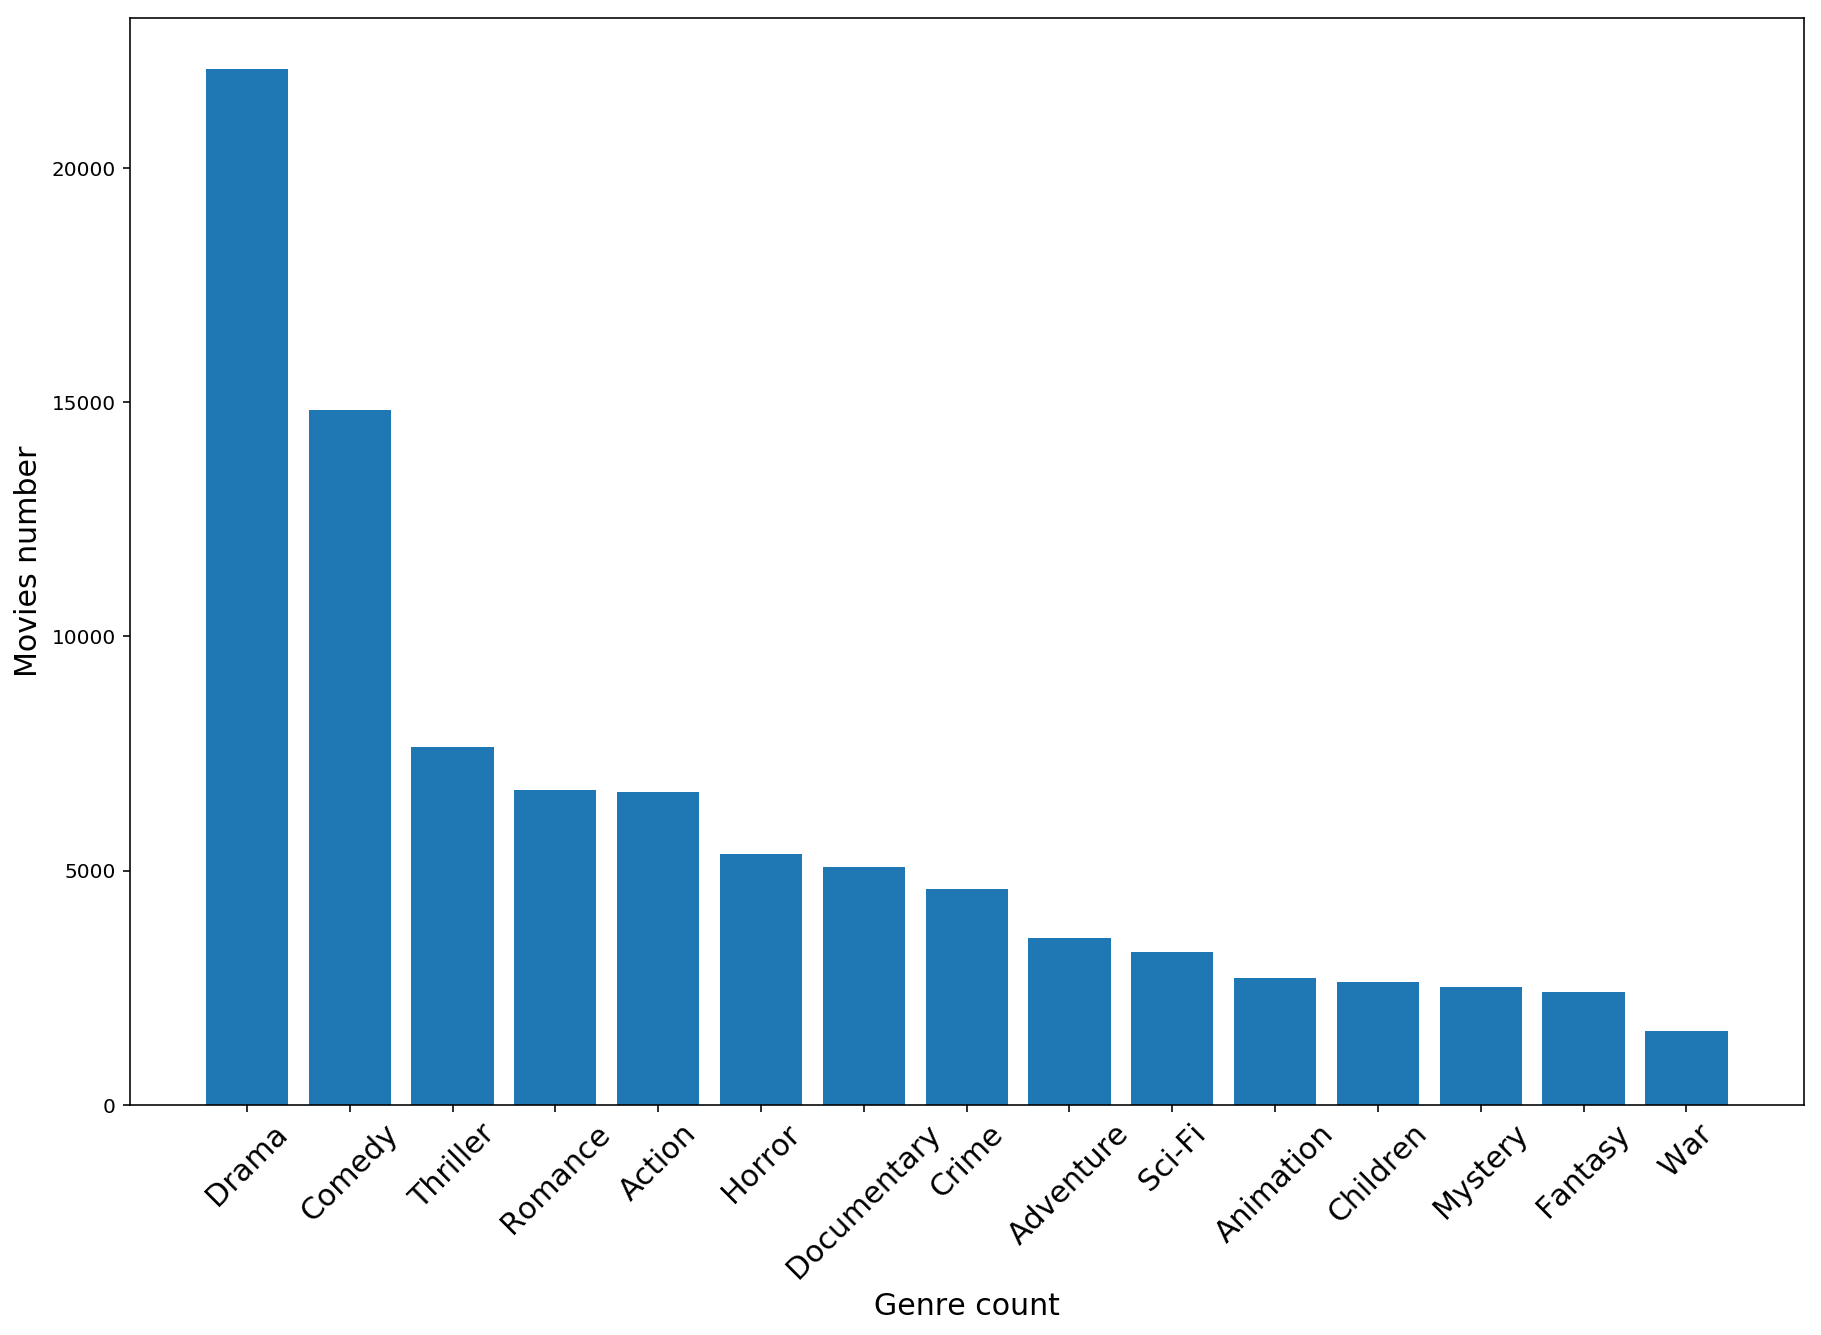

In [146]:
keys, values = zip(*top_genres)

f, ax = plt.subplots(figsize=(15, 10))
plt.xticks(rotation=45, fontsize=15)
plt.bar(keys, values, align="center")
plt.xlabel("Genre count", fontsize=15)
plt.ylabel("Movies number", fontsize=15)
plt.show()

### Актеры

Для решения задач ниже нужно воспользоваться файлами `ratings.csv`, `movies.csv`, `links.csv` и `tmdb.json`.

* `links.csv` - задает отображение из `movie_id` в `tmdb_movie_id` (подробное описание в `ml-25m-README.htm`)
* `tmdb.json` - содержит большое количество данных о фильмах в формате json (на каждой строчке отдельный json)

Задачи

1. Найти все фильмы, в которых играл `"id":31, "name":"Tom Hanks"`
2. Найти 10 актеров снявшихся в наибольшем числе фильмов. Вывести их имена и кол-во фильмов, в которых они снимались

In [243]:
######################################
######### YOUR CODE HERE #############
######################################

TMDB_PATH = os.path.join(DATA_PATH, 'tmdb.json')
tmdb = sc.textFile(TMDB_PATH)

In [244]:
tmdb = tmdb \
    .map(lambda s: json.loads(s))\
    .filter(lambda movie_info: 'title' in movie_info)\

In [245]:
tom_movies = tmdb \
    .map(lambda fjson: (fjson["id"], fjson["title"], fjson['casts']['cast']))\
    .flatMap(lambda fjson: [(cast, fjson[1]) for cast in fjson[2]]) \
    .filter(lambda info: info[0]['id'] == 31) \
    .map(lambda info: info[1]) \
    .distinct() \
    .collect() 

In [246]:
sorted(tom_movies)

['A Hologram for the King',
 'A League of Their Own',
 'And the Oscar Goes To...',
 'Angels & Demons',
 'Apollo 13',
 'Bachelor Party',
 'Beyond All Boundaries',
 'Beyond Boundaries: The Harvey Weinstein Scandal',
 'Big',
 'Bridge of Spies',
 'California Typewriter',
 'Captain Phillips',
 'Cars',
 'Cast Away',
 'Catch Me If You Can',
 "Charlie Wilson's War",
 'Cloud Atlas',
 "Defying the Nazis: The Sharps' War",
 'Dragnet',
 'Elvis Has Left the Building',
 'Every Time We Say Goodbye',
 'Everything Is Copy',
 'Extremely Loud & Incredibly Close',
 'Forrest Gump',
 'Hawaiian Vacation',
 "He Knows You're Alone",
 'Inferno',
 'Ithaca',
 'Joe Versus the Volcano',
 'Killing Lincoln',
 'Larry Crowne',
 'Magnificent Desolation: Walking on the Moon',
 'Mazes and Monsters',
 'Nothing in Common',
 'Partysaurus Rex',
 'Philadelphia',
 'Punchline',
 'Quincy',
 'Radio Flyer',
 'Return with Honor',
 'Road to Perdition',
 'Saving Mr. Banks',
 'Saving Private Ryan',
 'Shooting War',
 'Sleepless in Seatt

In [269]:
tmdb \
    .map(lambda fjson: (fjson["id"], fjson['casts']['cast']))\
    .flatMap(lambda fjson: [(fjson[0], cast) for cast in fjson[1]]) \
    .map(lambda info: (info[1]["name"], 1)) \
    .reduceByKey(lambda a, b: a + b) \
    .sortBy(lambda key_value: key_value[1], ascending=False)\
    .take(10)

[('Bess Flowers', 380),
 ('Frank Welker', 184),
 ('Christopher Lee', 175),
 ('Clarence Nash', 158),
 ('Irving Bacon', 152),
 ('John Carradine', 146),
 ('John Wayne', 142),
 ('Mel Blanc', 140),
 ('Samuel L. Jackson', 134),
 ('Eric Roberts', 133)]

In [306]:
links = sc.textFile(LINKS_PATH)

links = links \
    .map(lambda s: s.split(',')[::2])\
    .filter(lambda arr: arr[0].isdigit())\
    .keyBy(lambda arr: int(arr[0]))

links.take(5)

[(1, ['1', '862']),
 (2, ['2', '8844']),
 (3, ['3', '15602']),
 (4, ['4', '31357']),
 (5, ['5', '11862'])]

In [356]:
selected_genres, _ = zip(*top_genres)

### Доля жанра в течении времени

Для каждого жанра нужно построить как менялась доля вышедших фильмов данного жанра относительно всех остальных жанров.

Дату выхода фильма можно взять из файла `tmdb.json`.

(См. `plt.stackplot`)

In [357]:
######################################
######### YOUR CODE HERE #############
######################################

dates = tmdb \
    .keyBy(lambda info: info["id"])\
    .mapValues(lambda info: info["release_date"])\
    .filter(lambda key_value: key_value[1] != "")\
    .mapValues(lambda release_date: int(release_date.split("-")[0]))

dates.take(1)

[(862, 1995)]

In [358]:
genre_tmdb = genres \
    .join(links)\
    .filter(lambda key_value: key_value[1][1][1] != "")\
    .map(lambda key_value: (int(key_value[1][1][1]), key_value[1][0][1]))\
    .flatMapValues(lambda genre: genre.split('|'))

genre_tmdb.take(5)

[(150056, 'Comedy'),
 (98536, 'Drama'),
 (31357, 'Comedy'),
 (31357, 'Drama'),
 (31357, 'Romance')]

In [359]:
genre_dates = genre_tmdb \
    .filter(lambda key_value: key_value[1] in selected_genres)\
    .join(dates)

genre_dates.take(1)

[(16387, ('Adventure', 1966))]

In [371]:
year_number = genre_dates \
    .map(lambda key_value: (key_value[1][1], 1))\
    .reduceByKey(lambda a, b: a + b)

genre_year = genre_dates \
    .map(lambda key_value: (key_value[1], 1))\
    .filter(lambda key_value: 1920 <= key_value[0][1] <= 2019)\
    .reduceByKey(lambda a, b: a + b)\
    .map(lambda key_value: (key_value[0][1], (key_value[0][0], key_value[1])))\
    .join(year_number)\
    .mapValues(lambda info: (info[0][0], info[0][1] / info[1]))\
    .collect()

In [388]:
years, genre_info = zip(*genre_year)
all_years = list(range(1920, 2020))
y = np.zeros((len(selected_genres), len(all_years)))

genre_id = {genre: i for i, genre in enumerate(selected_genres)}
year_id = {year: i for i, year in enumerate(all_years)}

for year, (genre, ratio) in zip(years, genre_info):
    y[genre_id[genre]][year_id[year]] += ratio

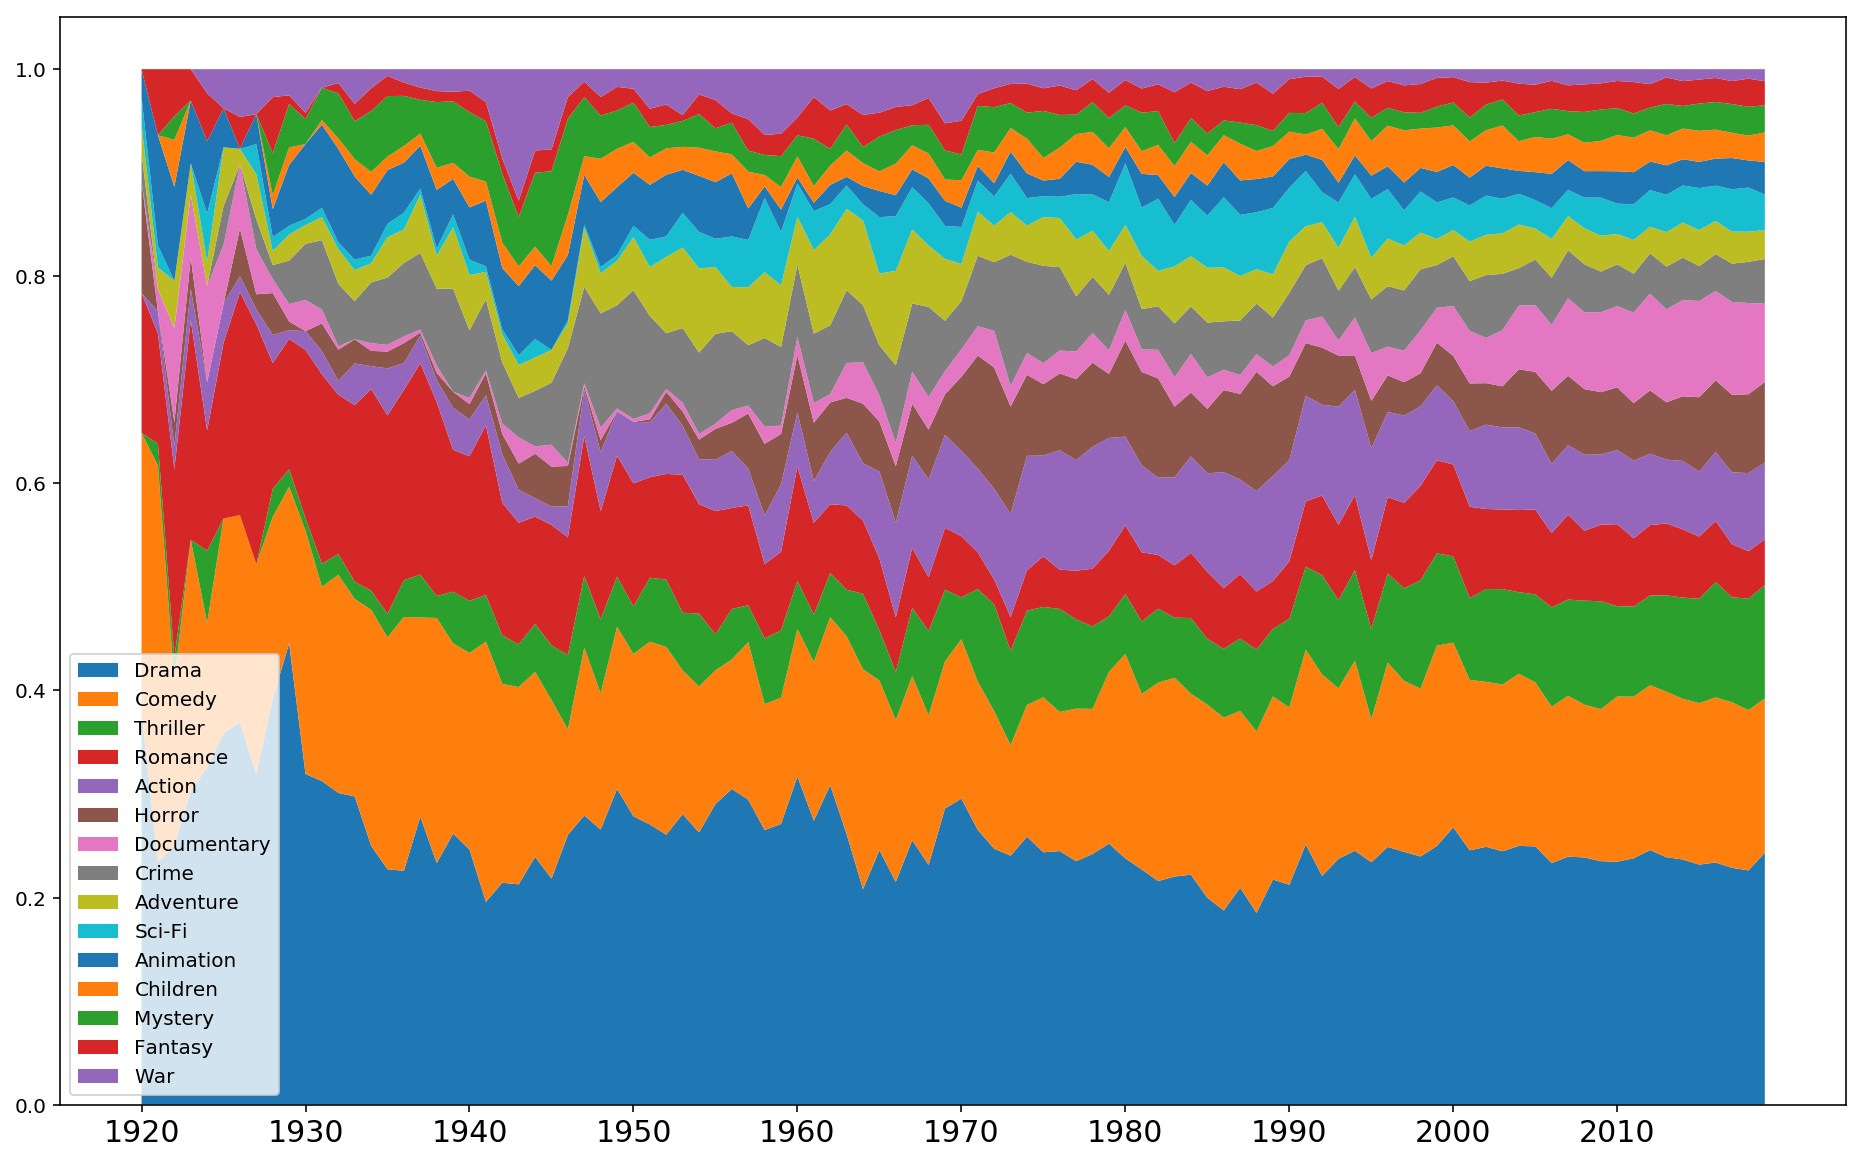

In [389]:
f, ax = plt.subplots(figsize=(16, 10))

ax.stackplot(unique_years, y, labels=selected_genres)
ax.legend(loc='lower left')
plt.xticks(unique_years[::10], fontsize=15)
plt.show()

### Окупаемость фильмов

Для каждого жанра посчитать `ROI = mean(revenue) / mean(budget)` и построить `barplot`, где по оси x будет название жанра, а по оси y - `ROI`

Данные о `revenue` и `budget` можно найти в файле `tmdb.json`.

In [332]:
######################################
######### YOUR CODE HERE #############
######################################
import numpy as np

info_rb = tmdb \
    .keyBy(lambda info: info["id"])\
    .mapValues(lambda info: (info["revenue"], info["budget"]))\
    .filter(lambda key_value: key_value[1][0] > 0 and key_value[1][1] > 0)
    
info_rb.take(5)

[(862, (373554033, 30000000)),
 (8844, (262797249, 65000000)),
 (31357, (81452156, 16000000)),
 (949, (187436818, 60000000)),
 (11860, (53672080, 58000000))]

In [344]:
roi = genre_tmdb \
    .filter(lambda key_value: key_value[1] in selected_genres)\
    .join(info_rb)\
    .map(lambda key_value: key_value[1])\
    .map(lambda info: (info[0], np.array(info[1])))\
    .reduceByKey(lambda a, b: a + b)\
    .map(lambda info: (info[0], info[1][0] / info[1][1]))\
    .sortBy(lambda key_value: key_value[1], ascending=False)\
    .take(15)

In [345]:
roi

[('Animation', 3.7445197085635504),
 ('Documentary', 3.3843579982146563),
 ('Adventure', 3.3840624526209813),
 ('Children', 3.3291997560353583),
 ('Romance', 3.2941355202081573),
 ('Horror', 3.1959638559421037),
 ('Sci-Fi', 3.1800291897917368),
 ('Fantasy', 3.1384939983294986),
 ('Comedy', 3.124316223182482),
 ('Action', 2.992968158514628),
 ('Thriller', 2.7649428596962435),
 ('Mystery', 2.7083818887680664),
 ('Drama', 2.653832739999457),
 ('Crime', 2.5523892383504583),
 ('War', 2.3528597490987844)]

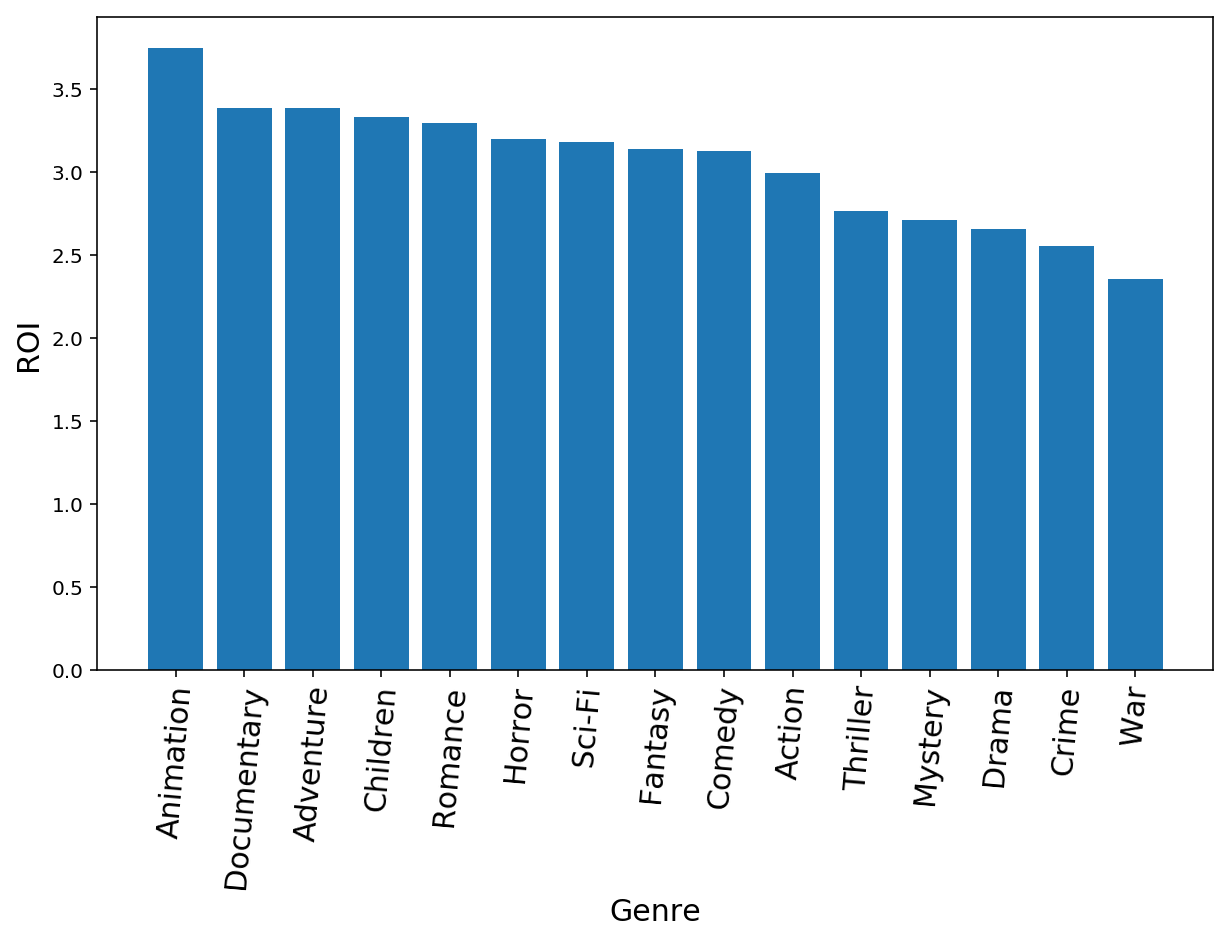

In [346]:
keys, values = zip(*roi)

f, ax = plt.subplots(figsize=(10, 6))
plt.xticks(rotation=85, fontsize=15)
plt.bar(keys, values, align="center")
plt.xlabel("Genre", fontsize=15)
plt.ylabel("ROI", fontsize=15)
plt.show()